# Препроцессинг
В этом ноутбуке мы будем строить pipeline препроцессинга данных на примере одного гидропоста

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime, timedelta

from rdm_helpers import get_meteo, helper_save, split_df_by, na_heat_map, interpolate_df, nse
import rdm_helpers

plt.style.use('ggplot')
pd.set_option('display.max_colwidth', 100)

Так как мы будем обучать отдельные модели для каждого гидропоста для удобства разделим подготовленные файлы по station_id

In [61]:
old_data_path = 'datasets/'
data_path = './data/hydro/'
df_names = ['daily', 'disch_d', 'ice']

In [62]:
# for df_name in df_names:
#     df = pd.read_pickle(old_data_path + "processed_data/"+ df_name + ".pkl")
#     for grp, df in split_df_by(df, 'station_id'):
#         df.to_csv(data_path + '0' + str(grp) + '_' + df_name + '.csv', index=False)

Рассмотрим станцию расположенную на зейском водохранилище

In [63]:
station_id = 6456#5024#5012

In [64]:
hydro_df = pd.read_csv(data_path + '/0' + str(station_id) + '_daily.csv', index_col = 'date', engine='python')
meteo_df, _ = get_meteo(station_id, 'datasets/')


### Данные с гидропостов

In [65]:
hydro_df
hydro_df.index = pd.to_datetime(hydro_df.index)

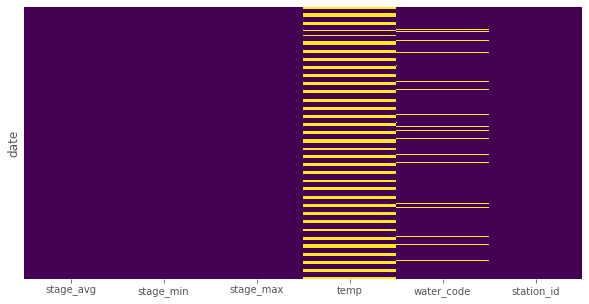

In [66]:
na_heat_map(hydro_df, figsize = (10, 5))

Интерполируем температуру воды

In [67]:
hydro_df = interpolate_df(hydro_df, cols = ['temp', 'stage_max'])

In [68]:
hydro_df['stage_delta'] = (hydro_df['stage_max'] - hydro_df['stage_min'])

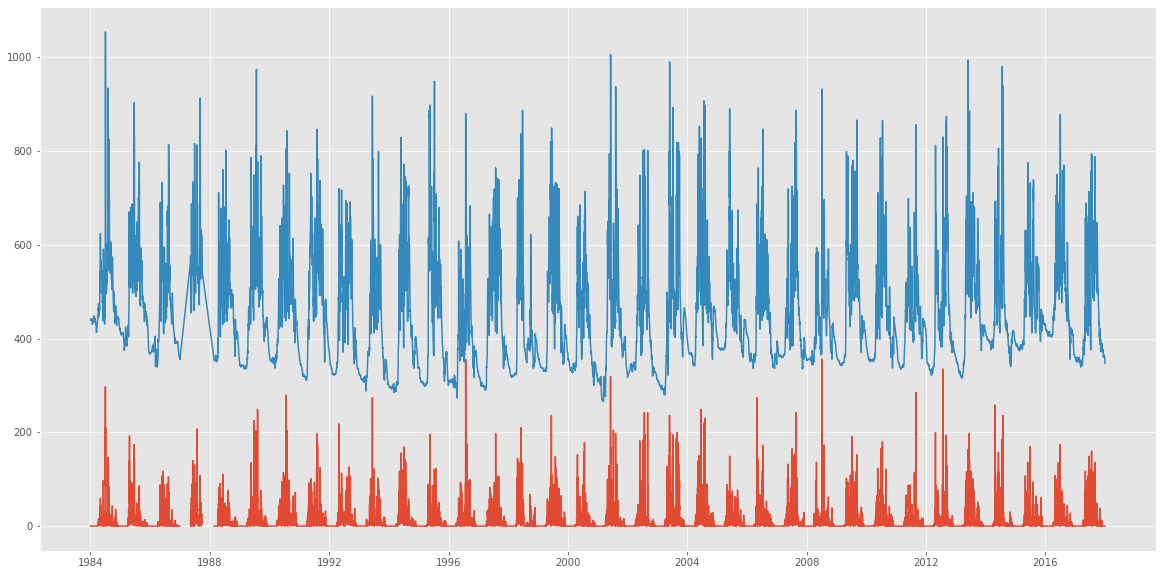

In [69]:
from rdm_helpers import plot_series
plot_series(hydro_df, cols = ['stage_delta', 'stage_max'])

In [70]:
hydro_df[hydro_df['water_code'] == 12]

,stage_avg,stage_min,stage_max,temp,water_code,station_id,stage_delta
date,,,,,,,


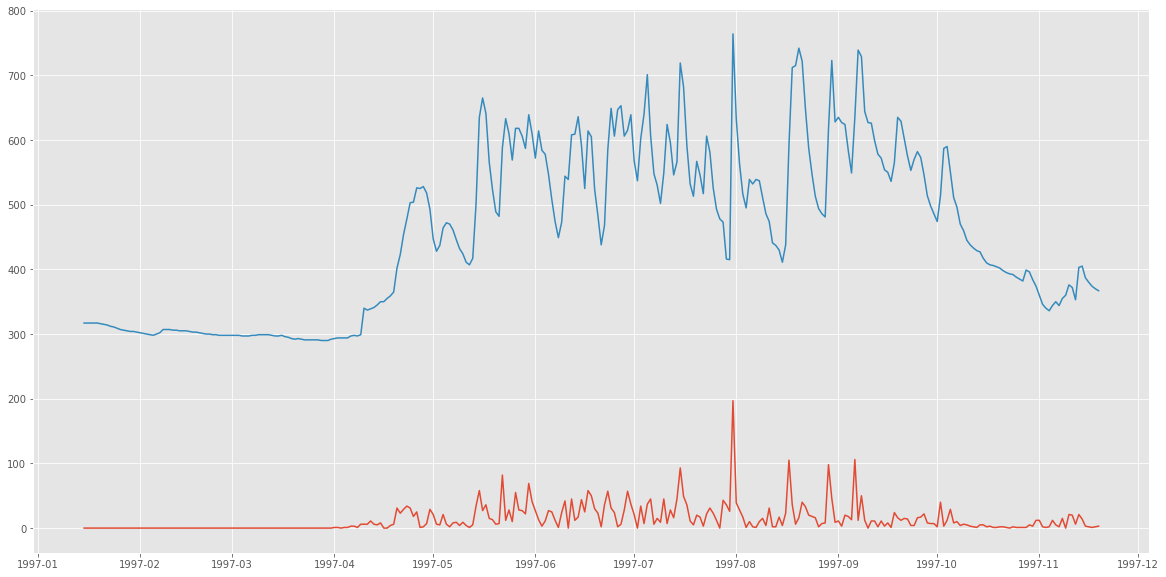

In [71]:
plot_series(hydro_df, cols = ['stage_delta', 'stage_max'], start_date = '1997-01-15', end_date = '1997-11-19')

Очевидно, что заторы влияют на уровень воды, однако это может происходить крайне редко

In [72]:
hydro_df['congestion_up'] = hydro_df['water_code'] == 11
hydro_df['congestion_down'] = hydro_df['water_code'] == 12

In [73]:
hydro_df = hydro_df.drop(['water_code', 'station_id', 'stage_min', 'stage_avg'], axis = 1)

<AxesSubplot:xlabel='date'>

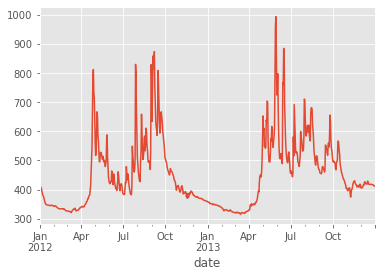

In [74]:
hydro_df['stage_max']['2012-01-01' : '2013-12-31'].plot()

In [75]:
hydro_df['doy'] = hydro_df.index.dayofyear

In [76]:
import statsmodels.api as sm

def substract_seasonality(series, period):
    return series - sm.tsa.seasonal_decompose(series, period = period).seasonal
hydro_df['seasonality'] = sm.tsa.seasonal_decompose(hydro_df['stage_max'], period = 365).seasonal

## Метео

In [77]:
meteo_df
meteo_df.index = pd.to_datetime(meteo_df.index)

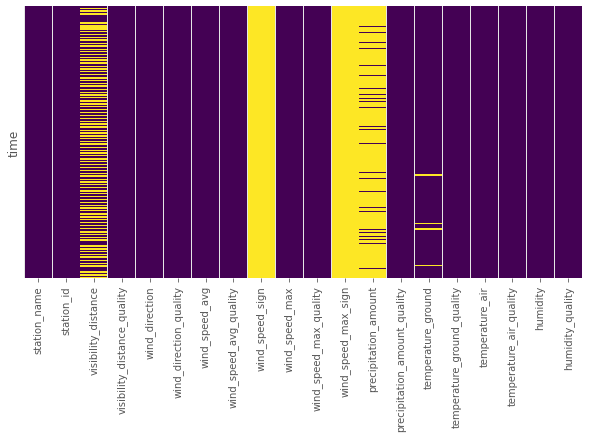

In [78]:
na_heat_map(meteo_df, figsize = (10, 5))

In [79]:
variebles = ['humidity', 'temperature_air', 'temperature_ground', 'precipitation_amount', 'wind_speed_max', 'wind_direction']
for var in variebles:
    meteo_df.loc[meteo_df[var + '_quality'] > 2, var] = np.nan

<AxesSubplot:xlabel='time'>

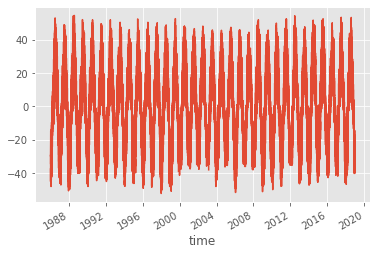

In [80]:
meteo_df['temperature_ground']['1985-01-01': '2019-01-04'].plot()

In [81]:
# meteo_df['hour'] = list(map(lambda x: x.hour, meteo_df.index.time))

In [82]:
meteo_df = meteo_df.resample('D')\
.agg({
    'precipitation_amount': 'sum',
    'temperature_air': 'mean',
    'temperature_ground': 'mean',
    'humidity': 'mean'
})

In [83]:
disch_df = pd.read_csv(data_path + '0' + str(station_id) + '_disch_d.csv', engine='python')
disch_df.dropna()

,date,consumption,station_id
0,1984-01-01,21.5,6456
1,1984-01-02,21.0,6456
2,1984-01-03,20.6,6456
3,1984-01-04,20.1,6456
4,1984-01-05,19.7,6456
...,...,...,...
10385,2013-12-26,41.6,6456
10386,2013-12-27,40.8,6456
10387,2013-12-28,40.1,6456
10388,2013-12-29,39.4,6456


<AxesSubplot:>

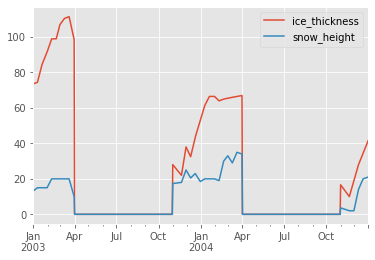

In [84]:
ice_df = pd.read_csv(data_path + '/0' + str(station_id) + '_ice.csv', index_col = 'date', engine='python')

pd.set_option('display.max_row', 1000)

idx = pd.date_range('1984-01-01', '2019-01-04')
#ice_df.loc[~((ice_df.index.month < 4) | (ice_df.index.month > 10))]# , ['ice_thickness', 'snow_height']] = 0
ice_df = ice_df.groupby('date').mean()

ice_df.index = pd.DatetimeIndex(ice_df.index)
ice_df = ice_df.drop(["place", 'station_id'], axis=1)
ice_df = ice_df.reindex(idx, fill_value=np.nan)
ice_df = interpolate_df(ice_df, cols = ['ice_thickness', 'snow_height'])
# na_heat_map(ice_df['2000-04':'2000-11'])
ice_df.loc[ice_df.index.month.isin(range(4, 11))] = 0
ice_df.loc[ice_df.index.year.isin(range(2003, 2005))].plot()

In [85]:
back = 30
period = 270

ice_df[['snow_height_ma','ice_thickness_ma']] = ice_df[['snow_height','ice_thickness']].shift(back).rolling(period).sum()
ice_df = ice_df[['snow_height_ma','ice_thickness_ma']]

In [86]:
meteo_df['humidity'] = meteo_df['humidity'].shift(7).rolling(10).sum()
# hydro_df['stage_max_ma_1'] = hydro_df['stage_max'].shift(1).rolling(3).mean()
hydro_df['stage_max_ma_2'] = hydro_df['stage_max'].rolling(2).apply(lambda x: x[1] - x[0])



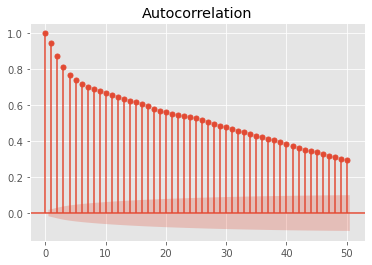

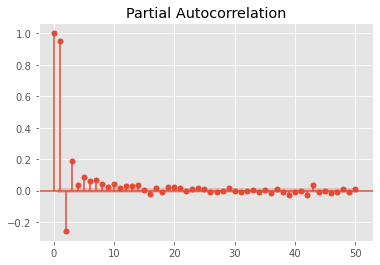

In [90]:
# hydro_df['stage_max_ma_2']

from pandas import read_csv
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_acf(hydro_df['stage_max'], lags= 50)


plot_pacf(hydro_df['stage_max'], lags=50)
pyplot.show()

In [ ]:
meteo_df = interpolate_df(meteo_df, cols = ['temperature_ground', 'humidity'])

In [34]:
meteo_df.index.rename('date', inplace=True)

In [35]:
def extract_seasonality(series, period):
    return sm.tsa.seasonal_decompose(series, period = period).seasonal
# meteo_df['temperature_ground'] = substract_seasonality(meteo_df['temperature_ground'], 365)
# meteo_df['temperature_ground'].plot()

In [36]:
# up_stations = [6323, 6299, 6265, 6302, 6319]
# up_stations_df = []
# for i in up_stations:
#     up_stations_df.append(pd.read_csv(data_path + '/0' + str(i) + '_daily.csv', index_col = 'date', engine='python'))

# for (i, d) in enumerate(up_stations_df):
#     d.index = pd.to_datetime(d.index)

#     d = interpolate_df(d, cols = ['stage_max'])
#     hydro_df['prev_' + str(i)] = d['stage_max']

In [37]:
idf = ice_df[['snow_height_ma','ice_thickness_ma']].copy()

In [38]:
df = pd.concat([hydro_df, meteo_df.reindex(hydro_df.index), ice_df.reindex(hydro_df.index)], axis = 1)


### Baseline

In [39]:
from rdm_helpers import TimeSeriesExtracter
df = TimeSeriesExtracter(['stage_delta', 'temp','precipitation_amount', 'temperature_ground', 'stage_max'],# 'humidity'], #+ ['prev_' + str(i) for i in range(4)],
                    [0,0,0,0,0],
                    [4,4,10,8,10]).fit_transform(df)
lag = 5
df['stage_max'] = df['stage_max'].shift(-lag)
df['doy'] = df['doy'].shift(-lag)
df['seasonality'] = df['seasonality'].shift(-lag)
df['humidity'] = df['humidity'].shift(-max(7, lag))
df['ice_thickness_ma'] = df['ice_thickness_ma'].shift(-lag)
df['snow_height_ma'] = df['snow_height_ma'].shift(-lag)

In [40]:
df = df['1987-01-01':]

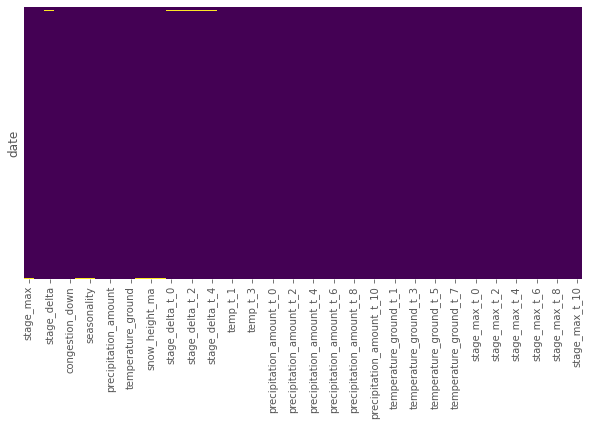

In [41]:
na_heat_map(df['1987-01-01':], figsize = (10, 5))

In [42]:
random_state = 228
label_name = 'stage_max'

In [43]:
from sklearn.model_selection import train_test_split
train_end = '2016-12-31'
test_start = '2017-01-01'
test_end = '2017-12-21'

X = df.drop(['temp', 'stage_delta', 'precipitation_amount', 'temperature_ground', 'temperature_air', 'congestion_up', 'congestion_down', label_name], axis = 1)
Y = df[label_name]

X_train, X_test, y_train, y_test = X[:train_end], X[test_start:test_end], Y[:train_end], Y[test_start:test_end] #train_test_split(df.drop([label_name], axis = 1), df[label_name], train_size=0.75, random_state=random_state)

In [44]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11049 entries, 1987-05-01 to 2017-12-31
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   doy                        11044 non-null  float64
 1   seasonality                11044 non-null  float64
 2   stage_max_ma_2             11049 non-null  float64
 3   humidity                   11042 non-null  float64
 4   snow_height_ma             11044 non-null  float64
 5   ice_thickness_ma           11044 non-null  float64
 6   stage_delta_t_0            11017 non-null  float64
 7   stage_delta_t_1            11017 non-null  float64
 8   stage_delta_t_2            11017 non-null  float64
 9   stage_delta_t_3            11017 non-null  float64
 10  stage_delta_t_4            11017 non-null  float64
 11  temp_t_0                   11049 non-null  float64
 12  temp_t_1                   11049 non-null  float64
 13  temp_t_2                   11

In [45]:
import lightgbm as lgb

parameters = {     
     'objective': 'rmse',
     'random_state': 42,
     'metric': ['l2', 'mae', 'mse'],
     'drop_rate':0.5,
     'learning_rate': 0.004,
     'feature_fraction': 0.8,
     'bagging_fraction': 0.4,
     "n_estimators":1500,
     "max_depth": 8,
     "num_leaves": 32,  
     "max_bin": 64,
     "random_state": random_state,
     "early_stopping_rounds":100,
    
}
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

model = lgb.LGBMRegressor() 

model.set_params(**parameters, metrics = ["mse", 'mae'])

model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False,
)

C:\Users\taras\Anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMRegressor(bagging_fraction=0.4, drop_rate=0.5, early_stopping_rounds=100,
              feature_fraction=0.8, learning_rate=0.004, max_bin=64,
              max_depth=8, metric=['l2', 'mae', 'mse'], metrics=['mse', 'mae'],
              n_estimators=1500, num_leaves=32, objective='rmse',
              random_state=228)

In [46]:
from sklearn.metrics import mean_absolute_error as mae
predict = model.predict(X_test)
true = y_test.values
print(mae(true, predict))
print(nse(true, predict))

40.23446597953381
0.376288804307376


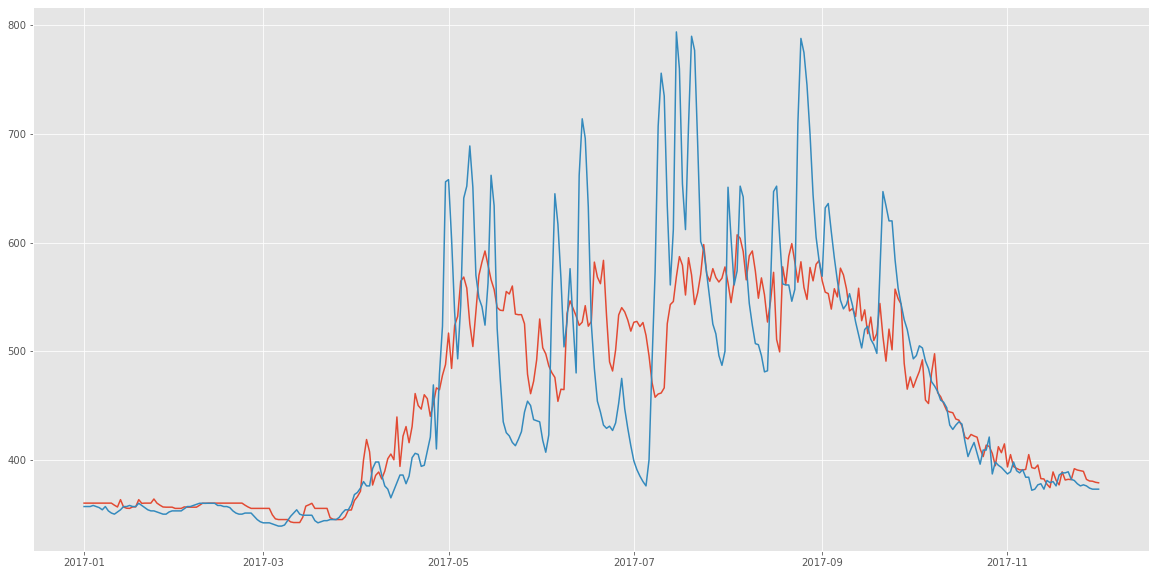

In [47]:
res = pd.DataFrame(y_test.copy())
res['predicted'] = predict
plot_series(res['2017-01-01':"2017-12-01"], cols = ['predicted', 'stage_max'])

In [48]:
import shap
X_importance = X_train
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_importance)

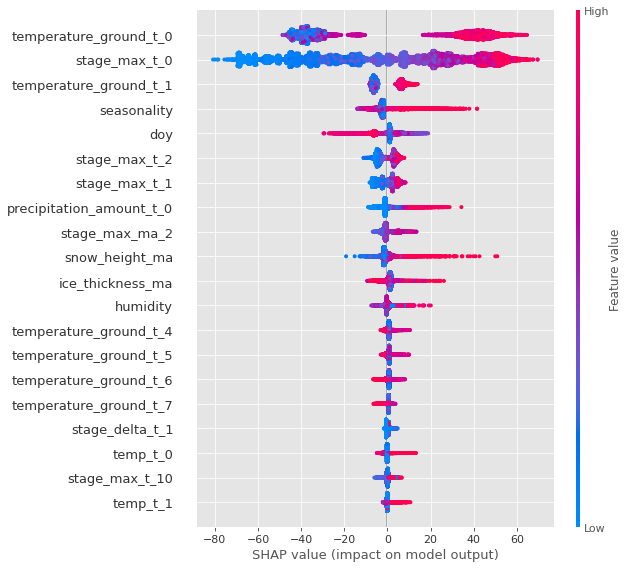

In [49]:
shap.summary_plot(shap_values, X_importance)

In [50]:
import statsmodels.api as sm
from rdm_helpers import TimeSeriesExtracter, substract_seasonality

class HydroTransformer():
    def __init__(self):
        self.is_fitted = False
        
    def fit(self, df):
        self.df = df.copy()
        self.is_fitted = True
        return self
          
    def transform(self):
        if not self.is_fitted:
            raise "not fitted"
        _lag = 10
            
        self.df.index = pd.to_datetime(self.df.index)
        self.df = interpolate_df(self.df, cols = ['temp', 'stage_max'])
        self.df['stage_delta'] = (self.df['stage_max'] - self.df['stage_min'])
        self.df = self.df.drop(['water_code', 'station_id', 'stage_min', 'stage_avg'], axis = 1)
        self.df['doy'] = self.df.index.dayofyear
        self.df['seasonality'] = sm.tsa.seasonal_decompose(self.df['stage_max'], period = 365).seasonal
        
        ##
        tsFeatures = ['stage_delta', 'temp', 'stage_max']
        self.df = TimeSeriesExtracter(tsFeatures,
                                        [0,0,0],
                                        [4,4,10]).fit_transform(self.df)

#         self.df['humidity'] = self.df['humidity'].shift(-max(7, lag))
#         self.df['ice_thickness_ma'] = self.df['ice_thickness_ma'].shift(-lag)
#         self.df['snow_height_ma'] = self.df['snow_height_ma'].shift(-lag)
        
        labels = []
        for i in range(1, 11):
#             ind = '%s%d'%("stage_max", i)
            
            self.df['%s%d'%("target", i)] = self.df['stage_max'].shift(-i)
            #self.df['%s%d'%("doy", i)] = self.df['doy'].shift(-i)
            #self.df['%s%d'%("seasonality", i)] = self.df['seasonality'].shift(-i)
            
#             df[ind] = df['stage_max'].shift(-i)
            labels.append('%s%d'%("target", i))
            
        to_drop = ['target'] + labels
    
        ##
        
        return self.df
        
    def fit_transform(self, df):
        return self.fit(df).transform()

In [51]:
class MeteoTransformer():
    def __init__(self):
        self.is_fitted = False
        
    def fit(self, df):
        self.df = df.copy()
        self.is_fitted = True
        return self
          
    def transform(self):
        if not self.is_fitted:
            raise "not fitted"
        _lag = 10
            
        self.df.index = pd.to_datetime(self.df.index)
        variebles = ['humidity',
                     'temperature_air',
                     'temperature_ground',
                     'precipitation_amount',
                     'wind_speed_max',
                     'wind_direction']
        for var in variebles:
            meteo_df.loc[meteo_df[var + '_quality'] > 2, var] = np.nan
        
        ##
        tsFeatures = ['stage_delta', 'temp', 'stage_max']
        self.df = TimeSeriesExtracter(tsFeatures,
                                        [0,0,0],
                                        [4,4,10]).fit_transform(self.df)
        
        meteo_df = meteo_df.resample('D')\
        .agg({
            'precipitation_amount': 'sum',
            'temperature_air': 'mean',
            'temperature_ground': 'mean',
            'humidity': 'mean'
        })

        self.df['humidity'] = self.df['humidity'].shift(-max(7, lag))
#         self.df['ice_thickness_ma'] = self.df['ice_thickness_ma'].shift(-lag)
#         self.df['snow_height_ma'] = self.df['snow_height_ma'].shift(-lag)
        
        labels = []
        for i in range(1, 11):
#             ind = '%s%d'%("stage_max", i)
            
            self.df['%s%d'%("target", i)] = self.df['stage_max'].shift(-i)
            #self.df['%s%d'%("doy", i)] = self.df['doy'].shift(-i)
            #self.df['%s%d'%("seasonality", i)] = self.df['seasonality'].shift(-i)
            
#             df[ind] = df['stage_max'].shift(-i)
            labels.append('%s%d'%("target", i))
            
        to_drop = ['target'] + labels
    
        ##
        
        return self.df
        
    def fit_transform(self, df):
        return self.fit(df).transform()

In [52]:
from gbmForecastModel import GBForecastModel

def train_test_split1(df, labels, train_start, train_end, test_start, test_end):
    y = df[labels]
    x = df.drop(labels + ["stage_max"], axis=1)

    X_train = x[train_start:train_end]
    X_test = x[test_start:test_end]
    y_train = y[train_start:train_end]
    y_test = y[test_start:test_end]
    return X_train, y_train, X_test, y_test

class RiverNodeModel():
    def __load__(self):
        self.hydro_df = pd.read_csv(self.data_path + 'hydro/0' + str(self.post_id) + '_daily.csv', index_col = 'date', engine='python')
#         self.ice_df = pd.read_csv(self.data_path + 'hydro/0' + str(self.post_id) + '_ice.csv', sep=';', engine='python')
#         self.meteo_df = get_meteo(self.post_id, path_to_data)
#         try:
#             self.disch_df = pd.read_csv(self.data_path + 'hydro/0' + str(self.post_id) + '_disch_d.csv', sep=';', engine='python')
#         except FileNotFoundError:
#             self.disch_df = None
            
    def __init__(self, post_id, data_path):
        self.post_id = post_id
        self.data_path = data_path
        
        _lag = 10
        
        parameters = {     
            'objective': 'rmse',
            'random_state': 42,
            'metric': ['l2', 'mae', 'mse'],
            'drop_rate':0.5,
            'learning_rate': 0.004,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.4,
            #     'bagging_freq': 10,
            "n_estimators":1000,
            "max_depth": 8,
            "num_leaves": 32,  
            "max_bin": 32,
            "n_jobs": 4,
            "verbosity ": -2,
            "early_stopping_rounds":100,
        }
        
        self.f_model = GBForecastModel(10)
        self.f_model.set_params([parameters] * _lag)
        self.__load__()
    
    def fit(self):
        _hdata =  HydroTransformer().fit_transform(self.hydro_df)
        
        train_end = '2016-12-31'
        test_start = '2017-01-01'
        test_end = '2017-12-15'
        train_start = '1985-12-31'
        
        labels = ['%s%d'%("target", i) for i in range(1, 11)]
        
        X_train, y_train, X_test, y_test\
            = train_test_split1(_hdata, labels, train_start, train_end, test_start, test_end)
        
        self.f_model.fit(X_train, y_train, X_test, y_test, labels)
        self.hydro_df = None
        return self
        
    def predict(self, X_start, X_end, sigma_X = None):
        if sigma_X != None:
            raise "Not implemented"
            
        self.__load__()
        _hdata =  HydroTransformer().fit_transform(self.hydro_df)[X_start : X_end]
        labels = ['%s%d'%("target", i) for i in range(1, 11)]
        X = _hdata.drop(labels + ["stage_max"], axis=1)
        
        return self.f_model.predict(X)

In [53]:
data_path = './data/'

In [54]:
nodeModel = RiverNodeModel(6456, data_path)

In [55]:
nodeModel.fit()

Found `early_stopping_rounds` in params. Will use it instead of argument


In [56]:
nodeModel.predict('2017-12-16', '2017-12-16')

array([[366.96083375, 367.10494977, 366.42982542, 368.36524784,
        366.03268469, 369.56903393, 370.07294077, 367.2542664 ,
        367.51398204, 365.96387141]])

In [57]:
hydro_df = pd.read_csv(data_path + 'hydro/0' + str(6456) + '_daily.csv', index_col = 'date', engine='python')
hydro_df.loc['2017-12-16' :'2017-12-26']


,stage_avg,stage_min,stage_max,temp,water_code,station_id
date,,,,,,
2017-12-16,365.0,365.0,365.0,NaN,46.0,6456
2017-12-17,363.0,363.0,363.0,NaN,46.0,6456
2017-12-18,363.0,363.0,363.0,NaN,46.0,6456
2017-12-19,362.0,362.0,362.0,NaN,46.0,6456
2017-12-20,362.0,362.0,362.0,NaN,46.0,6456
2017-12-21,362.0,362.0,362.0,NaN,46.0,6456
2017-12-22,361.0,361.0,361.0,NaN,46.0,6456
2017-12-23,363.0,363.0,363.0,NaN,46.0,6456
2017-12-24,362.0,362.0,362.0,NaN,46.0,6456


In [58]:
# HydroTransformer().fit_transform(hydro_df)['stage_max']['2000':'2001'].plot()

In [59]:
# HydroTransformer().fit_transform(hydro_df)
